# DMPS (Diffusion Map Particle System) Circle/Semi-Circle Sampling Algorithm

This notebook implements the Diffusion Map Particle System (DMPS) for particle evolution on 2D circular or semi-circular target distributions.

## Core Algorithm
- **Target Distribution**: Circular or semi-circular sample points
- **Kernel Method**: Gaussian kernel + diffusion map normalization
- **Particle Evolution**: Gradient flow iteration via spectral method
- **Acceleration**: Supports GPU (CuPy) and CPU modes

## 1. Import Libraries and GPU/CPU Backend Configuration

In [1]:
# This is a Gaussian example as a proof of concept.
import numpy as np
from scipy.linalg import svd
import matplotlib.pyplot as plt
import pandas as pd
import time

# --------------- Optional GPU backend (CuPy) ---------------
USE_GPU = True  # set False to force CPU even if CuPy is available
try:  # Attempt to import cupy
    import cupy as cp  # type: ignore
    GPU_AVAILABLE = True
except Exception:
    cp = None  # type: ignore
    GPU_AVAILABLE = False
USE_GPU = bool(USE_GPU and GPU_AVAILABLE)
if USE_GPU:
    from grad_ker1_gpu import grad_ker1  # xp-aware versions
    from K_tar_eval_gpu import K_tar_eval
else:
    from grad_ker1 import grad_ker1      # CPU fallbacks
    from K_tar_eval import K_tar_eval

print(f"[DEVICE] {'GPU' if USE_GPU else 'CPU'} mode active")

[DEVICE] GPU mode active


## 2. Define Timing and Progress Utility Functions

In [2]:
# ---------------- Timing / Progress Utilities ----------------
def _fmt_secs(s: float) -> str:
    s = max(0.0, float(s))
    h = int(s // 3600)
    m = int((s % 3600) // 60)
    sec = int(s % 60)
    if h > 0:
        return f"{h:02d}:{m:02d}:{sec:02d}"
    return f"{m:02d}:{sec:02d}"

def _print_phase(name: str, t_start: float) -> float:
    dt = time.time() - t_start
    print(f"[TIMER] {name}: {dt:.3f}s")
    return time.time()

_LAST_PROGRESS_LEN = 0
def _print_progress(curr: int, total: int, start_time: float, prefix: str = "") -> None:
    global _LAST_PROGRESS_LEN
    total = max(1, int(total))
    curr = min(max(0, curr), total)
    bar_len = 30
    filled = int(bar_len * curr / total)
    filled = min(filled, bar_len)
    bar = ("=" * filled) + (">" if filled < bar_len else "") + ("." * max(0, bar_len - filled - (0 if filled == bar_len else 1)))
    pct = 100.0 * curr / total
    elapsed = time.time() - start_time
    avg = elapsed / max(1, curr)
    eta = avg * (total - curr)
    msg = f"{prefix}[{bar}] {pct:5.1f}% | iter {curr}/{total} | elapsed {_fmt_secs(elapsed)} | eta {_fmt_secs(eta)}"
    prev = _LAST_PROGRESS_LEN
    clear = "\r" + (" " * prev) + "\r"
    print(clear, end="")
    print(msg, end="", flush=True)
    _LAST_PROGRESS_LEN = len(msg)

## 3. Configuration Parameters

- `USE_SEMICIRCLE`: True for semi-circle, False for full circle
- `n`: Number of target sample points (500)
- `d`: Dimensions (2D)
- `lambda_`: Anisotropy parameter (1 means isotropic)

In [3]:
# Set random seed for reproducibility (optional)
np.random.seed(0)
_t = time.time()

# ---------------- Configuration ----------------
USE_SEMICIRCLE = False  # Set False for full circle, True for semi-circle (upper half)

# Sample 500 points from a circle or semi-circle
n = 500
d = 2
lambda_ = 1  # Anisotropy parameter (stretches along x-axis)
# NOTE: lambda_ = 1 means NO anisotropy (isotropic circle)
# Set lambda_ > 1 to create non-uniform distribution with more points near y-axis

## 4. Generate Target Distribution Samples (Circle/Semi-Circle)

Two sampling methods available:
- **Method 1 (Currently Used)**: Rejection sampling - Gaussian sampling + normalization + filtering
- **Method 2 (Alternative)**: Polar coordinate sampling - Direct angle sampling converted to Cartesian coordinates

In [4]:
if USE_SEMICIRCLE:
    # ============================================================
    # METHOD 1: Rejection Sampling (same basis as full sphere)
    # ============================================================
    # This method uses the same Gaussian sampling + normalization as the full circle,
    # but filters to keep only points in the upper semi-circle (y >= 0).
    # Pros: Maintains same statistical properties as full circle method
    # Cons: Less efficient (rejects ~50% of samples)
    
    samples = []
    while len(samples) < n:
        # Over-sample to reduce number of rejection rounds
        batch_size = max(n - len(samples), int((n - len(samples)) * 2.5))
        
        # Gaussian sampling (same as full circle)
        u = np.random.normal(0, 1, (batch_size, d))
        u[:, 0] = lambda_ * u[:, 0]  # Apply anisotropy
        u_norm = np.linalg.norm(u, axis=1, keepdims=True)
        u_trans = u / (u_norm + 1e-12)
        
        # Rejection step: keep only upper semi-circle points
        valid = u_trans[:, 1] >= 0  # Filter for y >= 0
        samples.append(u_trans[valid, :])
    
    u_trans = np.vstack(samples)[:n, :]  # Take exactly n samples
    label = "semi-circle"
    
    # ============================================================
    # METHOD 2: Polar Coordinate Sampling 
    # ============================================================
    # This method directly samples angles in [0, π] and converts to Cartesian.
    # Pros: More efficient, more intuitive, flexible angle range
    # Cons: Different sampling method from full circle (not Gaussian-based)
    
    # theta = np.random.uniform(0, np.pi, (n, 1))
    # u_trans = np.hstack([
    #     np.cos(theta),  # x = cos(θ)
    #     np.sin(theta)   # y = sin(θ), ensures y >= 0
    # ])
    # 
    # # Apply anisotropy (stretch along x-axis)
    # u_trans[:, 0] = lambda_ * u_trans[:, 0]
    # u_norm = np.linalg.norm(u_trans, axis=1, keepdims=True)
    # u_trans = u_trans / (u_norm + 1e-12)
    # 
    # label = "semi-circle"
    
else:
    # ============================================================
    # METHOD 1: Gaussian Sampling (Marsaglia Method)
    # ============================================================
    # This method uses Gaussian sampling + normalization.
    # Pros: Generalizes to higher dimensions (3D, 4D, etc.)
    # Cons: Less intuitive, no explicit angle representation
    
    u = np.random.normal(0, 1, (n, d))
    u[:, 0] = lambda_ * u[:, 0]  # Apply anisotropy
    u_norm = np.linalg.norm(u, axis=1, keepdims=True)
    u_trans = u / (u_norm + 1e-12)
    
    label = "full circle"

    # ============================================================
    # METHOD 2: Polar Coordinate Sampling (RECOMMENDED)
    # ============================================================
    # Directly sample angles uniformly in [0, 2π] and convert to Cartesian.
    # Pros: Intuitive, efficient, explicitly angle-based
    # Cons: None for 2D case
    
    # theta = np.random.uniform(0, 2 * np.pi, (n, 1))
    # u_trans = np.hstack([
    #     np.cos(theta),  # x = cos(θ)
    #     np.sin(theta)   # y = sin(θ)
    # ])
    
    # # Apply anisotropy (stretch along x-axis) - Optional
    # # WARNING: This breaks the uniform angular distribution!
    # # After stretching and re-normalizing, points cluster near y-axis when lambda_ > 1
    # if lambda_ != 1:
    #     u_trans[:, 0] = lambda_ * u_trans[:, 0]
    #     u_norm = np.linalg.norm(u_trans, axis=1, keepdims=True)
    #     u_trans = u_trans / (u_norm + 1e-12)
    #     label = f"full circle (anisotropic λ={lambda_})"
    # else:
    #     label = "full circle (uniform)"

# Radial distance: slightly randomized around radius 1 (creates a thin annulus)
r = np.sqrt(np.random.rand(n, 1)) * 1/100 + 99/100
X_tar = r * u_trans
_t = _print_phase(f"Target sample generation ({label})", _t)
n = X_tar.shape[0]

[TIMER] Target sample generation (full circle): 0.010s


## 5. Build Gaussian Kernel Matrix and Normalization

Steps:
1. Compute Euclidean distances between sample points
2. Adaptively determine bandwidth parameter `epsilon`
3. Build Gaussian kernel matrix
4. Density normalization
5. Random-walk symmetric normalization

In [5]:
# Form the anisotropic graph Laplacian
sq_tar = np.sum(X_tar ** 2, axis=1)
H = sq_tar[:, None] + sq_tar[None, :] - 2 * (X_tar @ X_tar.T)
# epsilon = 0.5 * np.median(H) / np.log(n + 1)
epsilon = 1e-1
def ker(X):
    sq_tar = np.sum(X ** 2, axis=1)
    return np.exp(-(sq_tar[:, None] + sq_tar[None, :] - 2 * (X @ X.T)) / (2 * epsilon))

data_kernel = ker(X_tar)
_t = _print_phase("Base kernel (Gaussian) build", _t)
p_x = np.sqrt(np.sum(data_kernel, axis=1))
p_y = p_x.copy()
# Normalize kernel
data_kernel_norm = data_kernel / p_x[:, None] / p_y[None, :]
D_y = np.sum(data_kernel_norm, axis=0)

# Match MATLAB: 0.5*(A ./ D_y + A ./ D_y') where D_y is a row vector.
# First term divides columns by D_y (broadcast over last axis),
# second term explicitly divides rows by D_y (reshape as column vector).
rw_kernel = 0.5 * (data_kernel_norm / D_y + data_kernel_norm / D_y[:, None])
_t = _print_phase("Random-walk symmetric normalization", _t)

[TIMER] Base kernel (Gaussian) build: 0.052s
[TIMER] Random-walk symmetric normalization: 0.000s


## 6. SVD Decomposition and Inverse Kernel Computation

Extract spectral information from the kernel matrix via singular value decomposition, and compute regularized inverse weights for gradient calculations.

In [6]:
phi, s, _ = svd(rw_kernel)
_t = _print_phase("SVD on rw_kernel", _t)
lambda_ns = s
lambda_ = -lambda_ns + 1
inv_lambda = np.zeros_like(lambda_)
inv_lambda[1:] = 1 / lambda_[1:]
inv_lambda = inv_lambda * epsilon
inv_K = phi @ np.diag(inv_lambda) @ phi.T
_t = _print_phase("Primary inverse-like weights (inv_lambda)", _t)

tol = 1e-6
lambda_ns_mod = np.copy(lambda_ns)
lambda_ns_mod[lambda_ns_mod < tol] = 0
below_tol = np.sum(lambda_ns < tol)
above_tol = n - below_tol
reg = 0.001
lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = epsilon / (lambda_ns[mask] + reg)
inv_K_ns = phi @ np.diag(lambda_ns_inv) @ phi.T
_t = _print_phase("Regularized inverse weights (lambda_ns_inv)", _t)

[TIMER] SVD on rw_kernel: 0.098s
[TIMER] Primary inverse-like weights (inv_lambda): 0.010s
[TIMER] Regularized inverse weights (lambda_ns_inv): 0.005s


## 7. Particle Initialization

- `iter`: Number of iterations = 1000
- `h`: Step size = 2
- `m`: Initial number of particles ≈ 700
- Filter particle initial positions based on mode (full circle/semi-circle)

In [27]:
# Run algorithm
iter = 1000
h = 2
m = 700
u = np.random.normal(0, 1, (m, d))
u_norm = np.linalg.norm(u, axis=1, keepdims=True)
r = np.sqrt(np.random.rand(m, 1)) * 1/100 + 99/100
u_trans = u / u_norm
x_init = r * u_trans
# x_init = x_init[x_init[:, 1] > 0.95, :]

# Particle initialization strategy based on mode
if USE_SEMICIRCLE:
    # Semi-circle: only upper hemisphere (y > 0.9)
    x_init = x_init[x_init[:, 1] > 0.9, :]
else:
    # Full circle: both upper (y > 0.9) AND lower (y < -0.9) hemispheres
    x_init = x_init[x_init[:, 1] > 0.95, :]

m = x_init.shape[0]
x_t = np.zeros((m, d, iter), dtype=np.float64)  # Use float64 for precision
x_t[:, :, 0] = x_init
_t = _print_phase("Particle initialization", _t)

p_tar = np.sum(data_kernel, axis=0)
D = np.sum(data_kernel / np.sqrt(p_tar) / np.sqrt(p_tar)[:, None], axis=1)

inv_K_ns_s_ns = phi @ np.diag(lambda_ns_inv * inv_lambda * lambda_ns_inv) @ phi.T
lambda_s_s_ns = inv_lambda * inv_lambda * lambda_ns_inv
lambda_s_s_ns = lambda_s_s_ns[:above_tol]
lambda_ns_s_ns = lambda_ns_inv * inv_lambda * lambda_ns_inv
lambda_ns_s_ns = lambda_ns_s_ns[:above_tol]

print(f"Number of particles: {m}")
print(f"Effective eigenvalues: {above_tol} / {n}")

[TIMER] Particle initialization: 561.323s
Number of particles: 65
Effective eigenvalues: 52 / 500


## 8. DMPS Iteration Loop

Core algorithm: $x_{t+1} = x_t - \frac{h}{m} \nabla K(x_t, X_{tar})$

Supports both GPU and CPU modes with progress bar display.

In [28]:
sum_x = np.zeros((m, d))
loop_start = time.time()
total_loop = iter - 1

if USE_GPU:
    # Stage constants on GPU (keep float64 for precision)
    X_tar_gpu = cp.asarray(X_tar)
    p_tar_gpu = cp.asarray(p_tar)
    sq_tar_gpu = cp.asarray(sq_tar)
    D_gpu = cp.asarray(D)
    phi_gpu = cp.asarray(phi[:, :above_tol])
    lambda_ns_s_ns_gpu = cp.asarray(lambda_ns_s_ns)
    x_t_gpu = cp.asarray(x_t)
    diag_lambda_gpu = cp.diag(lambda_ns_s_ns_gpu)
    
    # Iteration loop (GPU)
    for t in range(iter - 1):
        x_slice = x_t_gpu[:, :, t]
        grad_matrix = grad_ker1(x_slice, X_tar_gpu, p_tar_gpu, sq_tar_gpu, D_gpu, epsilon)
        cross_matrix = K_tar_eval(X_tar_gpu, x_slice, p_tar_gpu, sq_tar_gpu, D_gpu, epsilon)
        
        # Original full-sphere algorithm (per-dimension loop)
        sum_x_gpu = cp.zeros((m, d))
        for i in range(d):
            sum_x_gpu[:, i] = cp.sum(
                grad_matrix[:, :, i] @ phi_gpu @ diag_lambda_gpu @ phi_gpu.T @ cross_matrix,
                axis=1
            )
        
        x_t_gpu[:, :, t + 1] = x_slice - (h / m) * sum_x_gpu
        done = t + 1
        if done == total_loop or (done % max(1, total_loop // 100) == 0):
            _print_progress(done, total_loop, loop_start, prefix="[DMPS-FULL-GPU] ")
    
    x_t = cp.asnumpy(x_t_gpu)
else:
    # CPU iteration loop
    for t in range(iter - 1):
        grad_matrix = grad_ker1(x_t[:, :, t], X_tar, p_tar, sq_tar, D, epsilon)
        cross_matrix = K_tar_eval(X_tar, x_t[:, :, t], p_tar, sq_tar, D, epsilon)
        for i in range(d):
            sum_x[:, i] = np.sum(
                grad_matrix[:, :, i] @ phi[:, :above_tol] @ np.diag(lambda_ns_s_ns) @ phi[:, :above_tol].T @ cross_matrix,
                axis=1
            )
        x_t[:, :, t + 1] = x_t[:, :, t] - h / m * sum_x
        done = t + 1
        if done == total_loop or (done % max(1, total_loop // 100) == 0):
            _print_progress(done, total_loop, loop_start, prefix="[DMPS-FULL-CPU] ")

print()
_t = _print_phase("Iteration loop total", loop_start)

[DMPS-FULL-GPU] [==============================] 100.0% | iter 999/999 | elapsed 00:02 | eta 00:00
[TIMER] Iteration loop total: 2.148s


## 9. Visualization of Results (2D/3D)

- **Blue dots**: Target distribution (`X_tar`)
- **Red solid circles**: Initial particle positions
- **Magenta hollow circles**: Final particle positions

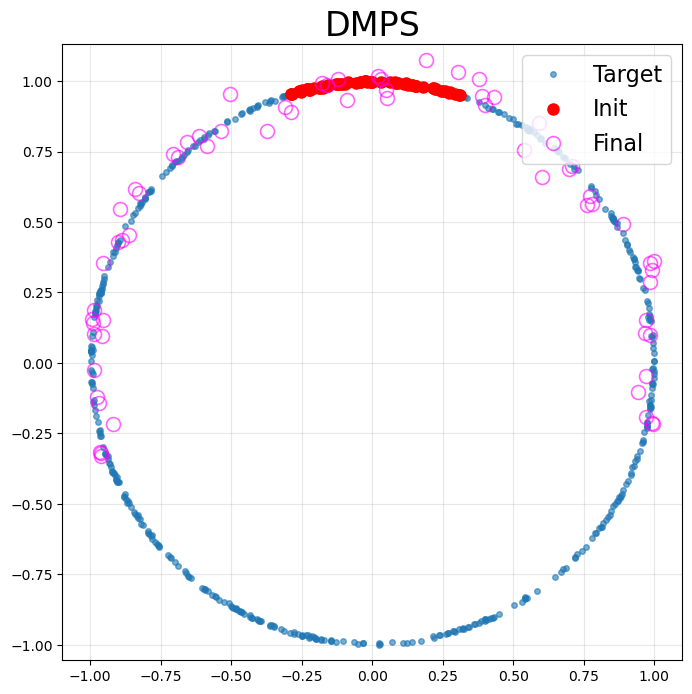

In [29]:
# Plotting results
if d == 2:
    plt.figure(figsize=(8, 8))
    plt.plot(X_tar[:, 0], X_tar[:, 1], 'o', markersize=4, alpha=0.6, label='Target')
    plt.plot(x_t[:, 0, 0], x_t[:, 1, 0], 'o', markersize=8, color='red', label='Init')  # Red solid circles
    plt.plot(x_t[:, 0, -1], x_t[:, 1, -1], 'o', markersize=10, markerfacecolor='none', markeredgecolor='magenta', markeredgewidth=1.2, alpha=0.6, label='Final')  # Green hollow circles
    plt.legend(fontsize=16, loc='upper right')
    plt.title('DMPS', fontsize=24)
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_tar[:, 0], X_tar[:, 1], X_tar[:, 2], s=20, alpha=0.6, label='Target')
    ax.scatter(x_t[:, 0, 0], x_t[:, 1, 0], x_t[:, 2, 0], s=50, marker='o', color='red', label='Init')  # Red solid circles
    ax.scatter(x_t[:, 0, -1], x_t[:, 1, -1], x_t[:, 2, -1], s=100, marker='o', facecolors='none', edgecolors='green', linewidths=0.8, alpha=0.5, label='Final')  # Green hollow circles
    ax.legend(fontsize=16, loc='upper right')
    plt.title('3D Results - DMPS', fontsize=24)
    plt.show()
    
    fig2 = plt.figure(figsize=(10, 8))
    ax2 = fig2.add_subplot(111, projection='3d')
    ax2.scatter(x_t[:, 0, 0], x_t[:, 1, 0], x_t[:, 2, 0], s=50, marker='o', color='red', label='Init')  # Red solid circles
    ax2.scatter(x_t[:, 0, -1], x_t[:, 1, -1], x_t[:, 2, -1], s=100, marker='o', facecolors='none', edgecolors='green', linewidths=0.8, alpha=0.5, label='Final')  # Green hollow circles
    ax2.legend(fontsize=16, loc='upper right')
    plt.title('3D Final State - DMPS', fontsize=24)
    plt.show()

## 10. Scatter Matrix Analysis

Multi-dimensional scatter matrix visualization of target distribution and final particle positions, with histograms on the diagonal.

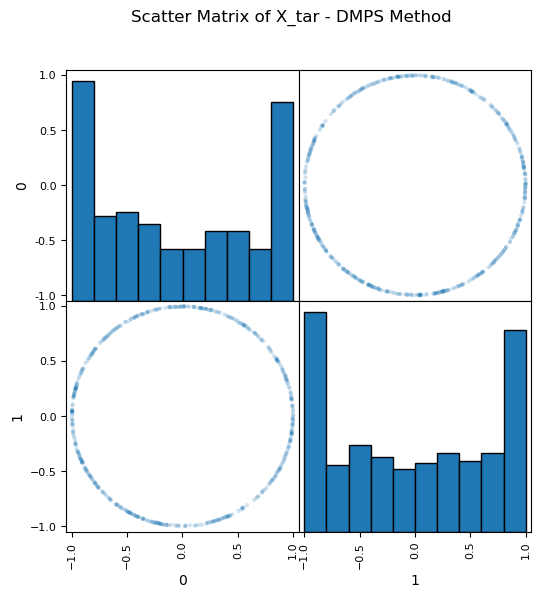

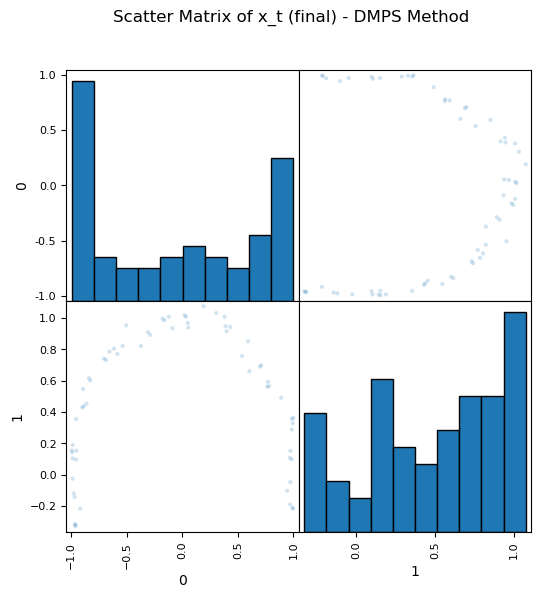

In [30]:
# Plot matrix (scatter matrix)
pd.plotting.scatter_matrix(
    pd.DataFrame(X_tar),
    alpha=0.2,
    figsize=(6, 6),
    diagonal='hist',
    hist_kwds={'edgecolor': 'black'}
)
plt.suptitle('Scatter Matrix of X_tar - DMPS Method')
plt.show()

pd.plotting.scatter_matrix(
    pd.DataFrame(x_t[:, :, -1]),
    alpha=0.2,
    figsize=(6, 6),
    diagonal='hist',
    hist_kwds={'edgecolor': 'black'}
)
plt.suptitle('Scatter Matrix of x_t (final) - DMPS Method')
plt.show()